<h1>Inference on Production<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Lightning-Module" data-toc-modified-id="Lightning-Module-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Lightning Module</a></span></li><li><span><a href="#Get-the-Checkpoint" data-toc-modified-id="Get-the-Checkpoint-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get the Checkpoint</a></span></li><li><span><a href="#Convert-to-ONNX-Format" data-toc-modified-id="Convert-to-ONNX-Format-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Convert to ONNX Format</a></span></li><li><span><a href="#Sample-Inference" data-toc-modified-id="Sample-Inference-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Sample Inference</a></span></li><li><span><a href="#References" data-toc-modified-id="References-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>References</a></span></li></ul></div>

1. Assume your team is working on a project where you need to work on some ML problems.
2. What if you pick one issue and solve it with the help of the PyTorch framework while your colleague does the same, using Tensorflow.
3. Both problems we know are part of a bigger project. Now, how to arrive at a common format to share the ML models.


<a target="_blank" href="https://onnx.ai/">ONNX: Open Neural Network Exchange</a> is one such open format that allows model interchange between various <a target="_blank" href="https://onnx.ai/supported-tools">ML frameworks and tools</a>.


**In this notebook, we will see how to convert a PyTorch Lightning saved checkpoint to the ONNX model.  Let's take the example of the checkpoint saved by the notebook on MNIST training.**

In [1]:
# !pip install onnxruntime onnx -q

In [8]:
import pytorch_lightning as pl
from torchmetrics import Accuracy
from torchmetrics import MeanMetric

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # filter UserWarning

## Lightning Module

The Lighting module gives us the model definition to load a model from checkpoints.

In [2]:
class LeNet5(pl.LightningModule):  # here nn.Module is replaced by LightningModule
    def __init__(self, learning_rate=0.01, num_classes=10):
        super().__init__()

        # Save the arguments as hyperparameters.
        self.save_hyperparameters()
        self.num_classes = num_classes

        # convolution layers
        self._body = nn.Sequential(
            # First convolution Layer
            # input size = (32, 32), output size = (28, 28)
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            # ReLU activation
            nn.ReLU(inplace=True),
            # Max pool 2-d
            nn.MaxPool2d(kernel_size=2),

            # Second convolution layer
            # input size = (14, 14), output size = (10, 10)
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # output size = (5, 5)
        )

        # Fully connected layers
        self._head = nn.Sequential(
            # First fully connected layer
            # in_features = total number of weights in last conv layer = 16 * 5 * 5
            nn.Linear(in_features=16 * 5 * 5, out_features=120),

            # ReLU activation
            nn.ReLU(inplace=True),

            # second fully connected layer
            # in_features = output of last linear layer = 120
            nn.Linear(in_features=120, out_features=84),

            # ReLU activation
            nn.ReLU(inplace=True),

            # Third fully connected layer. It is also the output layer
            # in_features = output of last linear layer = 84
            # and out_features = number of classes = 10 (MNIST data 0-9)
            nn.Linear(in_features=84, out_features=self.num_classes))


    def forward(self, x):
        # apply feature extractor
        x = self._body(x)
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weights_in_last conv_layer
        x = x.view(x.size()[0], -1)
        # apply classification head
        x = self._head(x)
        return x

## Get the Checkpoint

We are going to load one of the checkpoints saved during the last training.

We have written a helper function for it. It takes the log directory of PyTorch Lighting training and runs the version number to return the corresponding `.ckpt` path.

You’ll be familiar with  this function from the last unit.

In [3]:
import os

def get_latest_run_version_ckpt_epoch_no(lightning_logs_dir='lightning_logs', run_version=None):
    if run_version is None:
        run_version = 0
        for dir_name in os.listdir(lightning_logs_dir):
            if 'version' in dir_name:
                if int(dir_name.split('_')[1]) > run_version:
                    run_version = int(dir_name.split('_')[1])

    checkpoints_dir = os.path.join(lightning_logs_dir, 'version_{}'.format(run_version), 'checkpoints')

    files = os.listdir(checkpoints_dir)
    ckpt_filename = None
    for file in files:
        if file.endswith('.ckpt'):
            ckpt_filename = file

    if ckpt_filename is not None:
        ckpt_path = os.path.join(checkpoints_dir, ckpt_filename)
    else:
        print('CKPT file is not present')

    return ckpt_path

**Let us get the `.ckpt` model path.**

In [4]:
# get checkpoint path
ckpt_path = get_latest_run_version_ckpt_epoch_no(run_version=0)
print('ckpt_path: {}'.format(ckpt_path))

ckpt_path: lightning_logs/version_0/checkpoints/ckpt_009.ckpt


## Convert to ONNX Format

We have written a function to convert `.ckpt` model to `.onnx` model.

The function takes the model definition, `.ckpt` path, and the `.onnx` file path as arguments. And convert the `.ckpt` file to `.onnx` and return the `.onnx` path.

We find an `input_sample` being  used with `.ckpt` to `.onnx` conversion method `to_onnx`. This sample input fixes the input size, binding us to use the same  at the time of inference.

Get details <a target="_blank" href="https://pytorch-lightning.readthedocs.io/en/stable/common/production_inference.html">here</a>.

In [5]:
import onnxruntime

def convert_to_onnx_model(model, ckpt_path, onnx_path=None):

    # ONNX filename
    if onnx_path is None:
        onnx_path = ckpt_path[:-4] + 'onnx'

    # Load the checkpoint
    ckpt_model = LeNet5.load_from_checkpoint(ckpt_path)

    # Freeze the network
    ckpt_model.freeze()

    ckpt_model.eval()

    # Add a sample input. Here input shape = (batch_size, num_channel, height, width)
    input_sample = torch.randn((1, 1, 32, 32))

    # convert to ONNX model
    ckpt_model.to_onnx(onnx_path, input_sample, export_params=True)

    return onnx_path

**Let us convert `.ckpt` to `.onnx`.**

In [6]:
# initiate the model
model = LeNet5()

# convert the checkpoint to onnx format
onnx_model_path = convert_to_onnx_model(model, ckpt_path)
print('onnx_model_path: {}'.format(onnx_model_path))

onnx_model_path: lightning_logs/version_0/checkpoints/ckpt_009.onnx


## Sample Inference

**Steps for the inference with `.onnx` model:**

- Init the session. This is a one-time operation.


- Get the input name from the session. Again, one-time operation.


- Prepare input.


- Run the session with the input.

In [7]:
# Load the MNIST dataset and preprocess it (resize and normalize)
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32 as required by LeNet5
    transforms.ToTensor(),        # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])

# Download and load the MNIST dataset
mnist_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

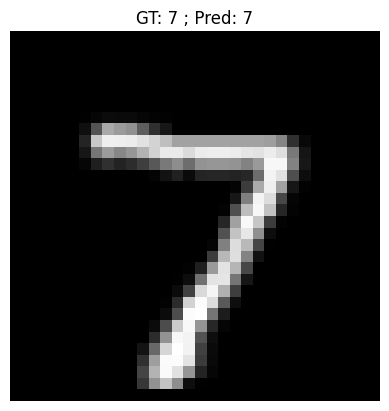

In [15]:
# Get a single image and label from MNIST
mnist_image, mnist_label = mnist_data[0]  # Take the first image and its true label

# The model expects a batch, so unsqueeze to add the batch dimension
mnist_image = mnist_image.unsqueeze(0)  # Shape: [1, 1, 32, 32]

# Convert the image to a NumPy array as expected by ONNX Runtime
mnist_image_np = mnist_image.numpy().astype(np.float32)

# Load the ONNX model and set up an inference session
sess = onnxruntime.InferenceSession(onnx_model_path)

# Get input name for the model
input_name = sess.get_inputs()[0].name

# Prepare inputs
inputs = {input_name: mnist_image_np}

# Perform inference with ONNX model
outputs = sess.run(None, inputs)

# The model output is a list of class logits. Get the predicted class by finding the index of the maximum logit.
predicted_class = np.argmax(outputs[0], axis=1)

# Plot the image with predicted and ground truth labels as title
plt.imshow(mnist_image.squeeze(), cmap='gray')
plt.title(f"GT: {mnist_label} ; Pred: {predicted_class[0]}")
plt.axis('off')
plt.show()

## References


1. <a target="_blank" href="https://pytorch-lightning.readthedocs.io/en/stable/common/production_inference.html">https://pytorch-lightning.readthedocs.io/en/stable/common/production_inference.html</a>
2. <a target="_blank" href="https://docs.microsoft.com/en-us/windows/ai/windows-ml/get-onnx-model">https://docs.microsoft.com/en-us/windows/ai/windows-ml/get-onnx-model</a>
3. <a target="_blank" href="https://onnx.ai/">https://onnx.ai/</a>
